In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
episodes = pd.read_csv("logs/phase_1_episodes_20251107_125500.csv")
steps = pd.read_csv("logs/phase_1_steps_20251107_125500.csv")

In [3]:
episodes["score_gap"] = episodes["score_p1"] - episodes["score_p2"]


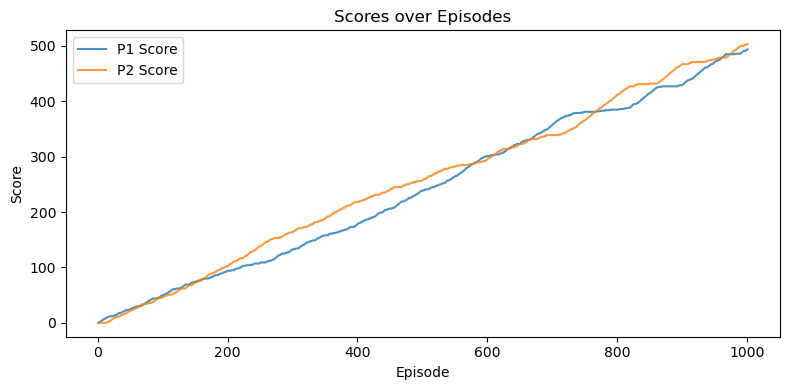

In [4]:
# === 1. Score trends ===

plt.figure(figsize=(8,4))
plt.plot(episodes["episode"], episodes["score_p1"], label="P1 Score", alpha=0.8)
plt.plot(episodes["episode"], episodes["score_p2"], label="P2 Score", alpha=0.8)
plt.title("Scores over Episodes")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

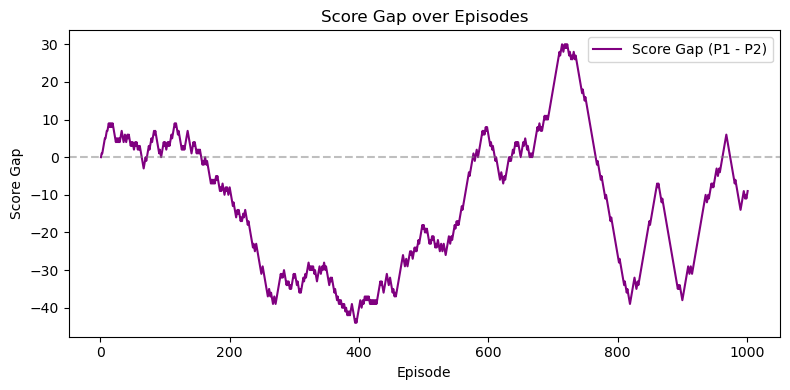

In [5]:
# === 2. Score gap ===

plt.figure(figsize=(8,4))
plt.plot(episodes["episode"], episodes["score_gap"], label="Score Gap (P1 - P2)", color="purple")
plt.title("Score Gap over Episodes")
plt.xlabel("Episode")
plt.ylabel("Score Gap")
plt.axhline(0, color="gray", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


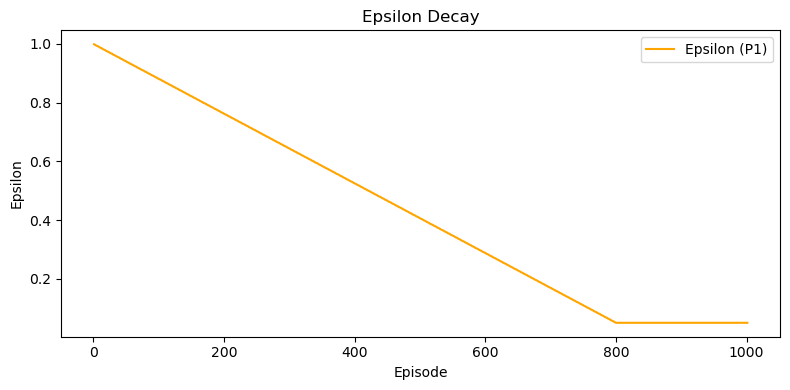

In [6]:
# === 3. Epsilon decay ===

plt.figure(figsize=(8,4))
plt.plot(episodes["episode"], episodes["epsilon_p1"], label="Epsilon (P1)", color="orange")
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.legend()
plt.tight_layout()
plt.show()

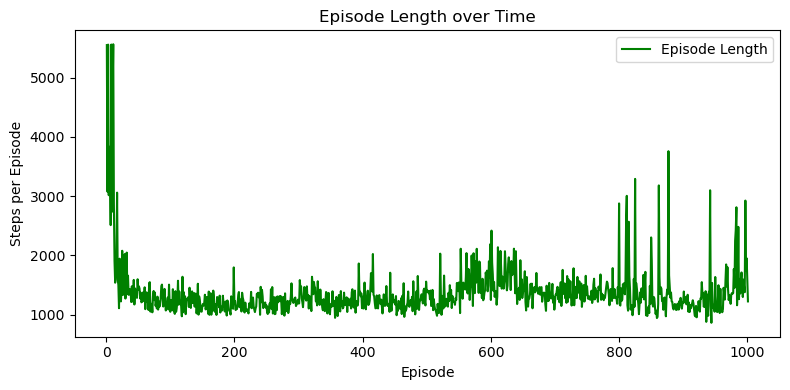

In [7]:
# === 4. Episode length ===

plt.figure(figsize=(8,4))
plt.plot(episodes["episode"], episodes["episode_step"], label="Episode Length", color="green")
plt.title("Episode Length over Time")
plt.xlabel("Episode")
plt.ylabel("Steps per Episode")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# === 5. Q-values (rolling average for clarity) ===

steps["q_p1_smooth"] = steps["q_p1"].rolling(200).mean()
steps["q_p2_smooth"] = steps["q_p2"].rolling(200).mean()

plt.figure(figsize=(8,4))
plt.plot(steps["episode_step"], steps["q_p1_smooth"], label="Q P1")
plt.plot(steps["episode_step"], steps["q_p2_smooth"], label="Q P2")
plt.title("Q-values (rolling mean)")
plt.xlabel("Step")
plt.ylabel("Q-value")
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'episode_step'

<Figure size 800x400 with 0 Axes>

In [9]:
# === 6. Losses ===

steps["loss_p1_smooth"] = steps["loss_p1"].rolling(200).mean()
steps["loss_p2_smooth"] = steps["loss_p2"].rolling(200).mean()

plt.figure(figsize=(8,4))
plt.plot(steps["episode_step"], steps["loss_p1_smooth"], label="Loss P1", alpha=0.8)
plt.plot(steps["episode_step"], steps["loss_p2_smooth"], label="Loss P2", alpha=0.8)
plt.title("Loss over Steps (smoothed)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'episode_step'

<Figure size 800x400 with 0 Axes>

In [10]:
# === 7. Rewards trend ===

steps["reward_p1_smooth"] = steps["reward_p1"].rolling(500).mean()
steps["reward_p2_smooth"] = steps["reward_p2"].rolling(500).mean()

plt.figure(figsize=(8,4))
plt.plot(steps["episode_step"], steps["reward_p1_smooth"], label="Reward P1", alpha=0.8)
plt.plot(steps["episode_step"], steps["reward_p2_smooth"], label="Reward P2", alpha=0.8)
plt.title("Reward Trend (smoothed)")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'episode_step'

<Figure size 800x400 with 0 Axes>

In [11]:
# Aggregate step-level stats per episode
agg = steps.groupby("episode").agg({
    "loss_p1": "mean",
    "loss_p2": "mean",
    "q_p1": "mean",
    "q_p2": "mean",
    "reward_p1": "sum",   # total reward per episode
    "reward_p2": "sum"
}).reset_index()

# Merge with episode-level info
merged = episodes.merge(agg, on="episode", how="left")

In [12]:
window = 10
merged["reward_p1_smooth"] = merged["reward_p1"].rolling(window).mean()
merged["reward_p2_smooth"] = merged["reward_p2"].rolling(window).mean()
merged["q_p1_smooth"] = merged["q_p1"].rolling(window).mean()
merged["q_p2_smooth"] = merged["q_p2"].rolling(window).mean()
merged["loss_p1_smooth"] = merged["loss_p1"].rolling(window).mean()
merged["loss_p2_smooth"] = merged["loss_p2"].rolling(window).mean()

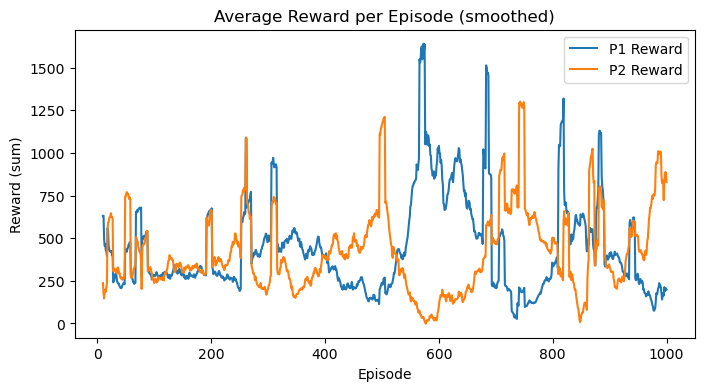

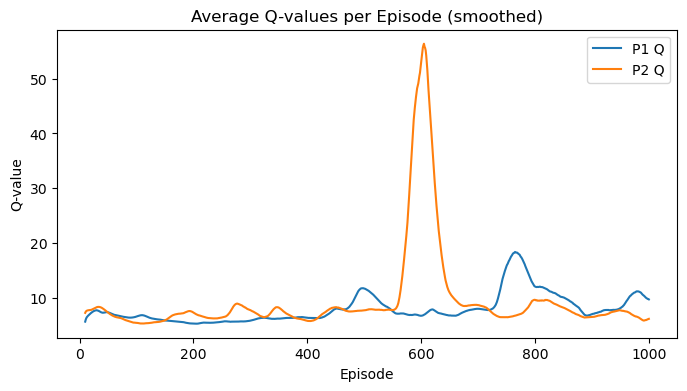

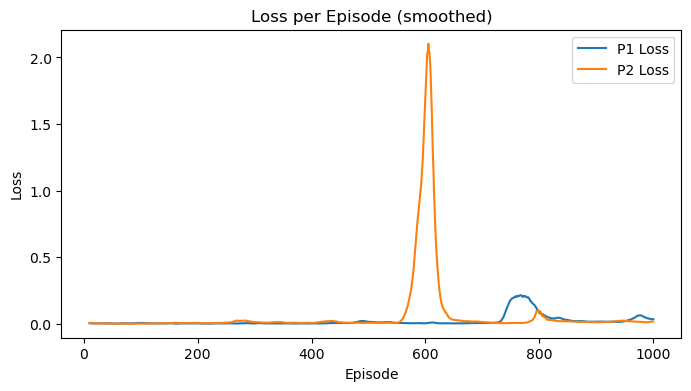

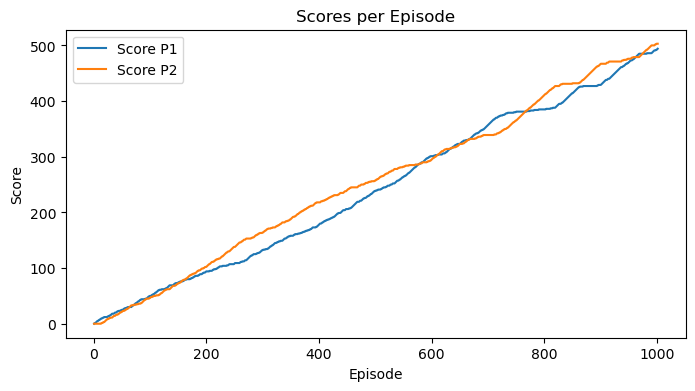

In [13]:
# --- Rewards ---
plt.figure(figsize=(8,4))
plt.plot(merged["episode"], merged["reward_p1_smooth"], label="P1 Reward")
plt.plot(merged["episode"], merged["reward_p2_smooth"], label="P2 Reward")
plt.title("Average Reward per Episode (smoothed)")
plt.xlabel("Episode")
plt.ylabel("Reward (sum)")
plt.legend()
plt.show()

# --- Q-values ---
plt.figure(figsize=(8,4))
plt.plot(merged["episode"], merged["q_p1_smooth"], label="P1 Q")
plt.plot(merged["episode"], merged["q_p2_smooth"], label="P2 Q")
plt.title("Average Q-values per Episode (smoothed)")
plt.xlabel("Episode")
plt.ylabel("Q-value")
plt.legend()
plt.show()

# --- Losses ---
plt.figure(figsize=(8,4))
plt.plot(merged["episode"], merged["loss_p1_smooth"], label="P1 Loss")
plt.plot(merged["episode"], merged["loss_p2_smooth"], label="P2 Loss")
plt.title("Loss per Episode (smoothed)")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --- Scores (already per episode) ---
plt.figure(figsize=(8,4))
plt.plot(merged["episode"], merged["score_p1"], label="Score P1")
plt.plot(merged["episode"], merged["score_p2"], label="Score P2")
plt.title("Scores per Episode")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()
plt.show()


In [14]:
import numpy as np
from scipy.stats import pearsonr

# --- Helper Functions ---
def smooth(y, box_pts=20):
    box = np.ones(box_pts) / box_pts
    return np.convolve(y, box, mode="same")

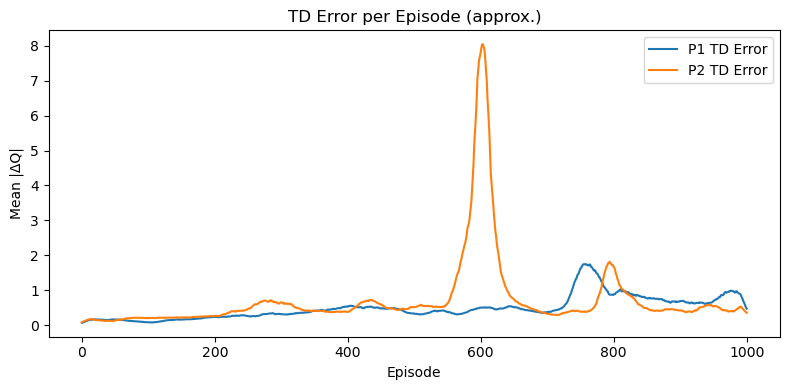

In [15]:
# TD Error Approximation (|ΔQ|)
# Using absolute diff between consecutive q-values as proxy

steps["td_error_p1"] = steps["q_p1"].diff().abs()
steps["td_error_p2"] = steps["q_p2"].diff().abs()

td_err = steps.groupby("episode")[["td_error_p1", "td_error_p2"]].mean().reset_index()
plt.figure(figsize=(8, 4))
plt.plot(td_err["episode"], smooth(td_err["td_error_p1"]), label="P1 TD Error")
plt.plot(td_err["episode"], smooth(td_err["td_error_p2"]), label="P2 TD Error")
plt.title("TD Error per Episode (approx.)")
plt.xlabel("Episode"); plt.ylabel("Mean |ΔQ|")
plt.legend(); plt.tight_layout()
plt.show()

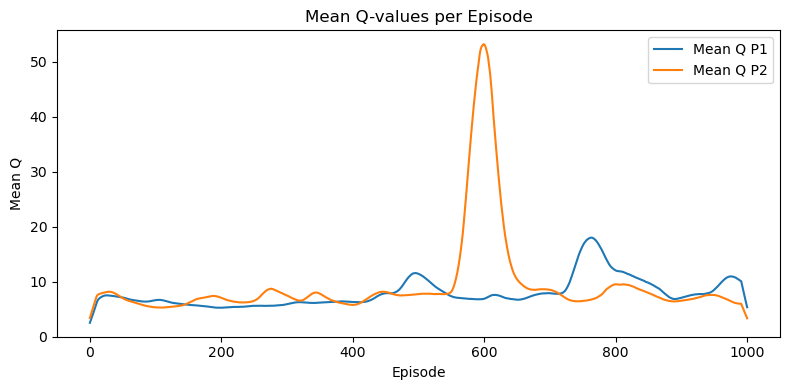

In [16]:
# Mean Q Values per Episode

mean_q = steps.groupby("episode")[["q_p1", "q_p2"]].mean().reset_index()
plt.figure(figsize=(8, 4))
plt.plot(mean_q["episode"], smooth(mean_q["q_p1"]), label="Mean Q P1")
plt.plot(mean_q["episode"], smooth(mean_q["q_p2"]), label="Mean Q P2")
plt.title("Mean Q-values per Episode")
plt.xlabel("Episode"); plt.ylabel("Mean Q")
plt.legend(); plt.tight_layout()
plt.show()

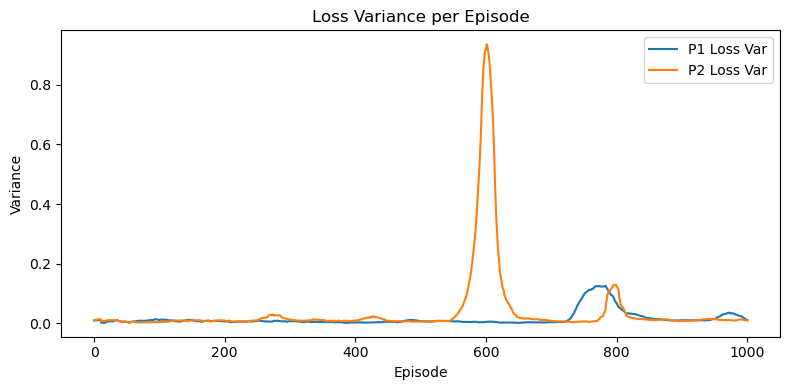

In [17]:
# === 3. Loss Variance (proxy for gradient stability) ===
loss_var = steps.groupby("episode")[["loss_p1", "loss_p2"]].std().reset_index()
plt.figure(figsize=(8, 4))
plt.plot(loss_var["episode"], smooth(loss_var["loss_p1"].fillna(0)), label="P1 Loss Var")
plt.plot(loss_var["episode"], smooth(loss_var["loss_p2"].fillna(0)), label="P2 Loss Var")
plt.title("Loss Variance per Episode")
plt.xlabel("Episode"); plt.ylabel("Variance")
plt.legend(); plt.tight_layout()
plt.show()

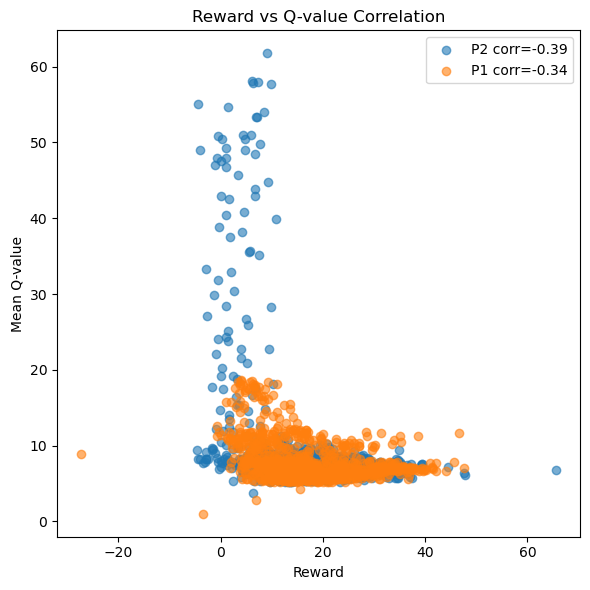

Reward-Q correlation: P1=-0.338, P2=-0.385


In [18]:
# === 4. Reward vs Q Correlation ===
reward_q = steps.groupby("episode")[["reward_p1", "reward_p2", "q_p1", "q_p2"]].mean().reset_index()
corr_p1, _ = pearsonr(reward_q["reward_p1"], reward_q["q_p1"])
corr_p2, _ = pearsonr(reward_q["reward_p2"], reward_q["q_p2"])

plt.figure(figsize=(6, 6))
plt.scatter(reward_q["reward_p2"], reward_q["q_p2"], alpha=0.6, label=f"P2 corr={corr_p2:.2f}")
plt.scatter(reward_q["reward_p1"], reward_q["q_p1"], alpha=0.6, label=f"P1 corr={corr_p1:.2f}")
plt.title("Reward vs Q-value Correlation")
plt.xlabel("Reward"); plt.ylabel("Mean Q-value")
plt.legend(); plt.tight_layout()
plt.show()

print(f"Reward-Q correlation: P1={corr_p1:.3f}, P2={corr_p2:.3f}")

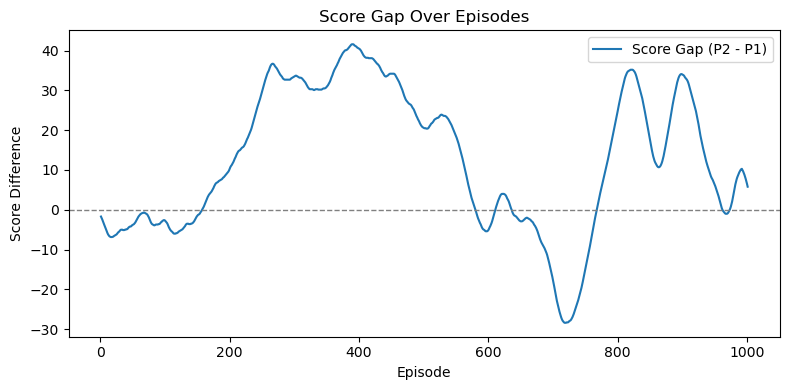

In [19]:
# === 5. Score Gap Evolution ===
episodes["score_gap"] = episodes["score_p2"] - episodes["score_p1"]
plt.figure(figsize=(8, 4))
plt.plot(episodes["episode"], smooth(episodes["score_gap"]), label="Score Gap (P2 - P1)")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Score Gap Over Episodes")
plt.xlabel("Episode"); plt.ylabel("Score Difference")
plt.legend(); plt.tight_layout()
plt.show()


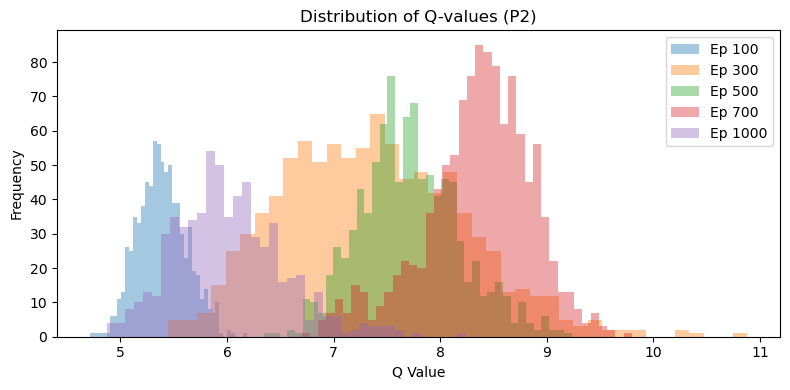

In [20]:
# === 6. Q Distribution Snapshots ===
checkpoints = [100, 300, 500, 700, 1000]
plt.figure(figsize=(8, 4))
for c in checkpoints:
    subset = steps.loc[(steps["episode"] >= c-20) & (steps["episode"] <= c+20)]
    plt.hist(subset["q_p2"], bins=40, alpha=0.4, label=f"Ep {c}")
plt.title("Distribution of Q-values (P2)")
plt.xlabel("Q Value"); plt.ylabel("Frequency")
plt.legend(); plt.tight_layout()
plt.show()



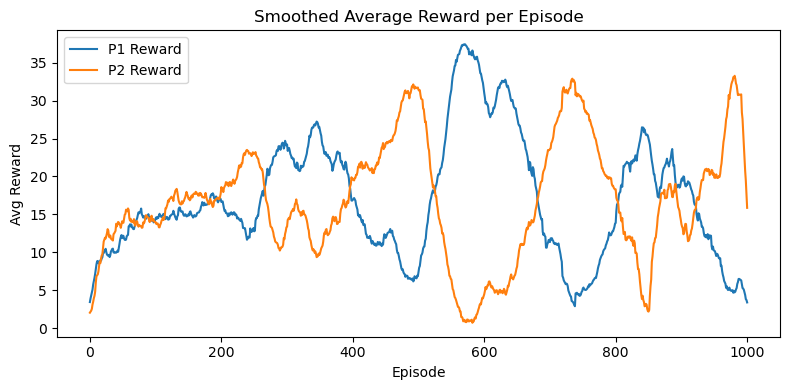

In [21]:
# === 7. Smoothed Reward Trend ===
rew = steps.groupby("episode")[["reward_p1", "reward_p2"]].mean().reset_index()
plt.figure(figsize=(8, 4))
plt.plot(rew["episode"], smooth(rew["reward_p1"]), label="P1 Reward")
plt.plot(rew["episode"], smooth(rew["reward_p2"]), label="P2 Reward")
plt.title("Smoothed Average Reward per Episode")
plt.xlabel("Episode"); plt.ylabel("Avg Reward")
plt.legend(); plt.tight_layout()
plt.show()

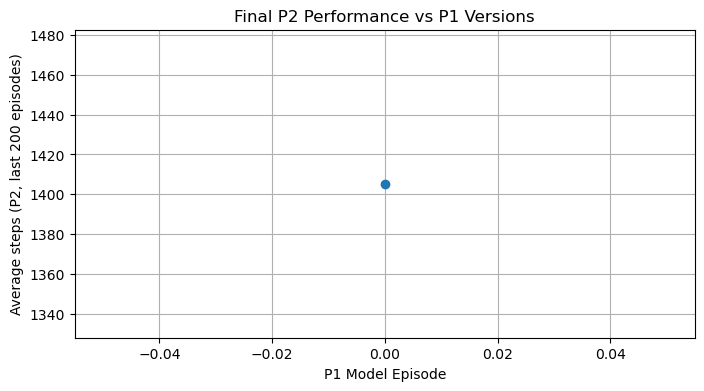

In [22]:
# average episode steps for different p1 episode
p1_episodes = np.arange(0, 1001, 50)
avg_steps = []  # fill with average P2 reward vs each P1 snapshot

# Focus only on the final 200 P2 episodes (e.g. last 200)
final_p2_range = episodes['episode'].max() - 500
df_final = episodes[episodes['episode'] >= final_p2_range]

# Group by P1 version and compute average P2 reward
avg_steps = df_final.groupby('opponent_ep')['episode_step'].mean()


# Plot
plt.figure(figsize=(8,4))
plt.plot(avg_steps.index, avg_steps.values, marker='o')
plt.title('Final P2 Performance vs P1 Versions')
plt.xlabel('P1 Model Episode')
plt.ylabel('Average steps (P2, last 200 episodes)')
plt.grid(True)
plt.show()

In [47]:
df = pd.read_csv("logs/phase_1_steps_20251107_125500.csv")
# Get the last record for each episode
last_records = df.groupby('episode').last().reset_index()

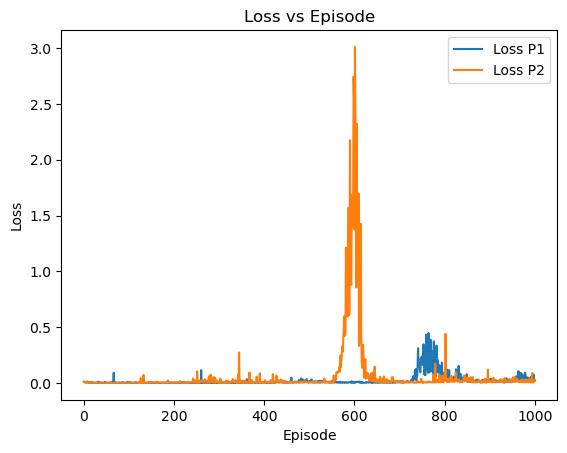

In [32]:
# Plot loss for both players
plt.figure()
plt.plot(last_records['episode'], last_records['loss_p1'], label='Loss P1')
plt.plot(last_records['episode'], last_records['loss_p2'], label='Loss P2')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss vs Episode')
plt.legend()
plt.show()

(125,)
(125,)


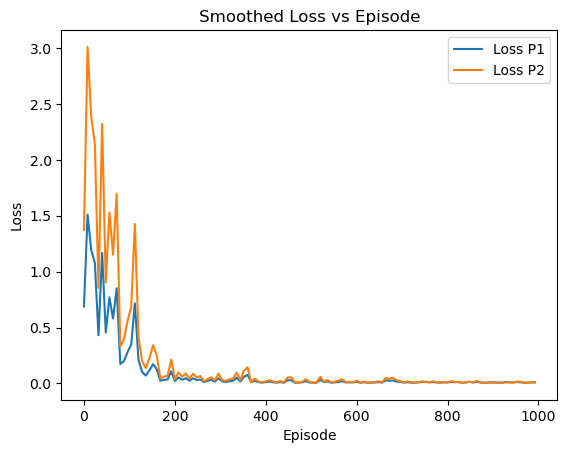

In [56]:
# Plot loss for both players
plt.figure()
p1 = (last_records['loss_p2'][600:725,]+last_records['loss_p1'][600:725,])/2
print(last_records['loss_p2'][600:725,].shape)
print(p1.shape)
plt.plot([x for x in range(0,1000,8)], p1, label='Loss P1')
plt.plot([x for x in range(0,1000,8)], last_records['loss_p2'][600:725,], label='Loss P2')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Smoothed Loss vs Episode')
plt.legend()
plt.show()

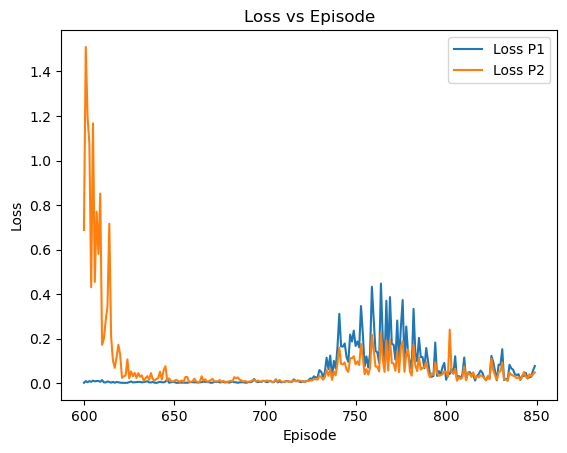

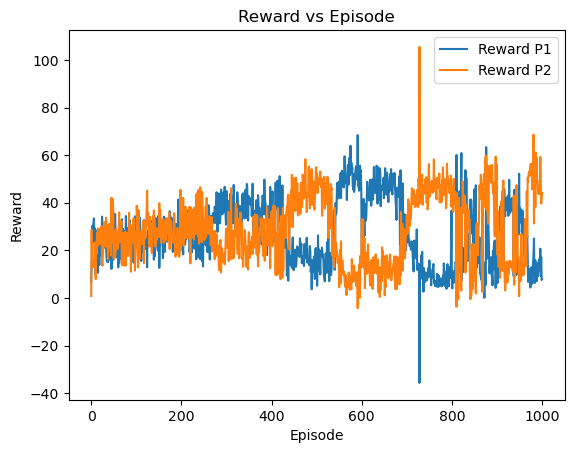

In [ ]:




# Plot reward for both players
plt.figure()
plt.plot(last_records['episode'], last_records['reward_p1'], label='Reward P1')
plt.plot(last_records['episode'], last_records['reward_p2'], label='Reward P2')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward vs Episode')
plt.legend()
plt.show()


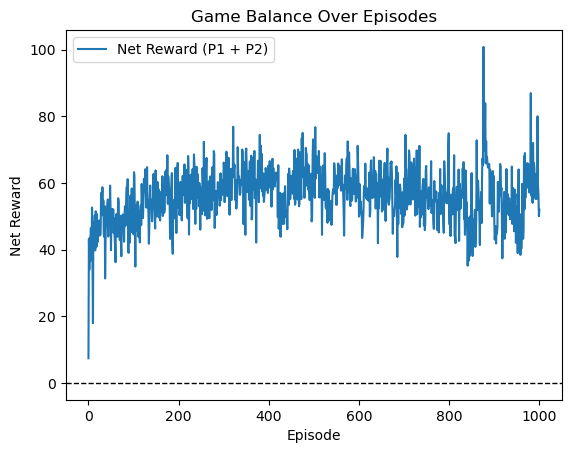

In [27]:
last_records['net_reward'] = last_records['reward_p1'] + last_records['reward_p2']

plt.figure()
plt.plot(last_records['episode'], last_records['net_reward'], label='Net Reward (P1 + P2)')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Net Reward')
plt.title('Game Balance Over Episodes')
plt.legend()
plt.show()